In [1]:
import os
import torch    
import h5py
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from autoencoder import SparseAutoencoder
import torch.nn.functional as F
from models.networks import get_model
from data_utils.dataloader import get_loader
from PyTorch_CIFAR10.cifar10_models.vgg import vgg13_bn
from data_utils.data_stats import *
from utils.metrics import topk_acc, real_acc, AverageMeter
from matplotlib import pyplot as plt
from models.networks import get_model
from scipy.stats import pearsonr
%matplotlib inline
plt.rcParams.update({'font.size': 18})


Load trained autoencoder

In [2]:
cfg = {
    "seed": 49,
    "buffer_mult": 384,
    "l1_coeff": 3e-4,
    "dict_mult": 3, #expansion factor of the latent representation
    "d_activation": 1024,
    "enc_dtype":"fp32",
}

sparse_autoencoder = SparseAutoencoder(cfg)
sparse_autoencoder.load_state_dict(torch.load('SAE_100_epochs_bs_32_CIFAR10_test_B_12-Wi_1024_postskip.pt'))

<All keys matched successfully>

Check whether unit norm decoder rows have been enforced

Load MLP

In [3]:
dataset = 'cifar10'                 # One of cifar10, cifar100, stl10, imagenet or imagenet21
architecture = 'B_12-Wi_1024'
data_resolution = 32                # Resolution of data as it is stored
crop_resolution = 64                # Resolution of fine-tuned model (64 for all models we provide)
num_classes = CLASS_DICT[dataset]
data_path = './beton/'
eval_batch_size = 100
checkpoint = 'in21k_cifar10'        # This means you want the network pre-trained on ImageNet21k and finetuned on CIFAR10
torch.backends.cuda.matmul.allow_tf32 = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the model and specify the pre-trained weights
mlp = get_model(architecture=architecture, resolution=crop_resolution, num_classes=CLASS_DICT[dataset],
                  checkpoint='in21k_cifar10')

Weights already downloaded
Load_state output <All keys matched successfully>


Load dataset and targets

In [4]:
cifar10_labels = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}

class TrainDataset(Dataset):
    def __init__(self, data, targets):
        assert len(data.shape) == 4 and data.shape[1] == 3
        self.data = F.interpolate(data, scale_factor=2, mode='nearest')
        self.data = torch.reshape(self.data, (self.data.shape[0], -1))
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx, :]
        target = self.targets[idx]

        return sample, target


f = h5py.File("/home/fmassari/scaling_mlps/ims_cifar10_train.h5", "r")

for key in f.keys():
    print(key) 
    print(type(f[key])) # get the object type   

group = f[key]
images = torch.tensor(group[:]).float()
print("Images Shape:", images.shape)

f = h5py.File("/home/fmassari/scaling_mlps/targs_cifar10_train.h5", "r")

for key in f.keys():
    print(key) 
    print(type(f[key])) # get the object type   

group = f[key]
targets = torch.tensor(group[:]).float()
print("Targets Shape:", targets.shape)

train_data = TrainDataset(images[:10000], targets[:10000])
del images
del targets

images
<class 'h5py._hl.dataset.Dataset'>
Images Shape: torch.Size([50000, 3, 32, 32])
targets
<class 'h5py._hl.dataset.Dataset'>
Targets Shape: torch.Size([50000])


## Experiments

Replace MLP activations with AE reconstructions to see how much of the accuracy is "explained" by the AE features (i.e., hidden activations)

In [5]:
encoded = []
counter = 0
mse_loss = 0
def replace_hook(module, input, output):
    global mse_loss, counter
    _, rec, acts, loss, _ = sparse_autoencoder(input[0])
    encoded.append(acts.detach().clone())
    mse_loss = (mse_loss*counter + loss.detach().clone().item())/(counter+1)
    counter += 1

    out = (module.weight@rec.transpose(0, 1)).transpose(0, 1)
    return out

hook_mlp = mlp.linear_out.register_forward_hook(replace_hook)

with torch.no_grad():
    nsamples = train_data.targets.shape[0]
    total_acc, total_top5 = AverageMeter(), AverageMeter()
    batchsize = 100
    mlp.eval()
    dataloader = DataLoader(train_data, batch_size=batchsize, shuffle=False)
    
    for imgs, targs in tqdm(dataloader, desc="Evaluation"):
        preds = mlp(imgs)
        acc, _ = topk_acc(preds, targs, k=5, avg=True)
        total_acc.update(acc, batchsize)

hook_mlp.remove()
print(f'Accuracy: {total_acc.get_avg(percentage=True)}')
print(f'SAE MSE: {mse_loss}')

Evaluation:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluation: 100%|██████████| 100/100 [01:28<00:00,  1.13it/s]

Accuracy: 99.88999950885773
SAE MSE: 10.853495750427246


MLP accuracy without replacement

In [6]:
with torch.no_grad():
    nsamples = train_data.targets.shape[0]
    total_acc_raw = AverageMeter()
    batchsize = 100
    mlp.eval()
    dataloader = DataLoader(train_data, batch_size=batchsize, shuffle=False)
    
    for imgs, targs in tqdm(dataloader, desc="Evaluation"):
        preds = mlp(imgs)
        acc, _ = topk_acc(preds, targs, k=5, avg=True)
        total_acc_raw.update(acc, batchsize)

print(f'Accuracy: {total_acc_raw.get_avg(percentage=True)}')
print(f'% of accuracy explained by features: {100*total_acc.get_avg(percentage=True)/total_acc_raw.get_avg(percentage=True)}')

Evaluation:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluation: 100%|██████████| 100/100 [01:17<00:00,  1.29it/s]

Accuracy: 99.89999955892563
% of accuracy explained by features: 99.98998993982778


In [6]:
del mlp #deleting to save memory. If you have more memory you can get rid of this.
encoded = np.concatenate(encoded, axis=0)

# uncomment if you want to save the feature activations for the test set 
with h5py.File(architecture + '_enc_' + dataset + '_train_1st_10k_postskip.h5', 'w') as hf:
    hf.create_dataset('feature vectors', data=encoded)

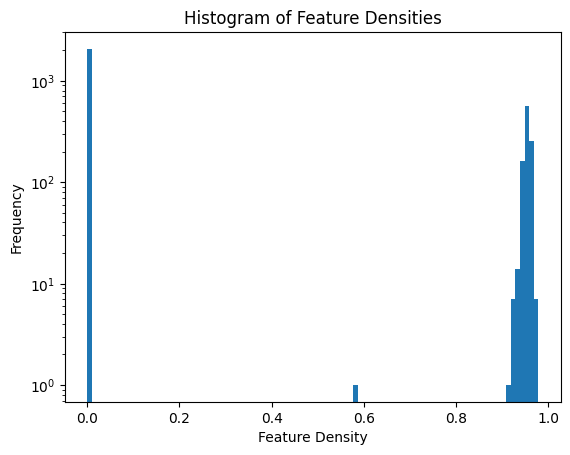

Number of active units in hidden AE-layer:  tensor(2437.)
Feature densities of active units:  tensor([9.4910e-01, 5.0000e-04, 9.5000e-01,  ..., 4.0000e-04, 9.4950e-01,
        9.5660e-01])


In [7]:
encoded = torch.from_numpy(encoded)
feature_densities = (encoded != 0).float().mean(dim=0).detach()
plt.hist(feature_densities, bins=100, log=True)
plt.xlabel('Feature Density')
plt.ylabel('Frequency')
plt.title('Histogram of Feature Densities')
plt.show()

active_units = feature_densities != 0
print("Number of active units in hidden AE-layer: ", active_units.float().sum())
print("Feature densities of active units: ", feature_densities[active_units])

## Interpreting non-silent features

Finding class-related features by sensitivity, since we have too many for manual inspection.

In [8]:
class2find = "horse"
alive_idxs = torch.nonzero(active_units)
idxs4labels = {v: k for k, v in cifar10_labels.items()}
l_idx = idxs4labels[class2find]
l_occur_mask = (train_data.targets == l_idx)
n_occur = l_occur_mask.sum()
n_active_cond = (encoded[l_occur_mask, :] != 0).sum(dim=0)
sensitivity = n_active_cond / n_occur
active_mask = (encoded != 0)
n_active = active_mask.sum(dim=0)
n_occur_cond = (active_mask[l_occur_mask, :]).sum(dim=0)
specificity = torch.nan_to_num(n_occur_cond / n_active)
score = sensitivity + specificity
_, top_fs = score.topk(10)
print(f"Features most selective/sensitive to {class2find}-class: {top_fs.detach().numpy()}")
print(f"Associated sensitivities: {sensitivity.detach().numpy().round(decimals=2)[top_fs]}")
print(f"Associated specificities: {specificity.detach().numpy().round(decimals=2)[top_fs]}")

Features most selective/sensitive to horse-class: [2813  195 2533   59 3041 3039  953 2935  477 2645]
Associated sensitivities: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Associated specificities: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


Display top 10 activating inputs with corresponding labels for a given non-silent feature

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Showing top activating inputs for feature 195:


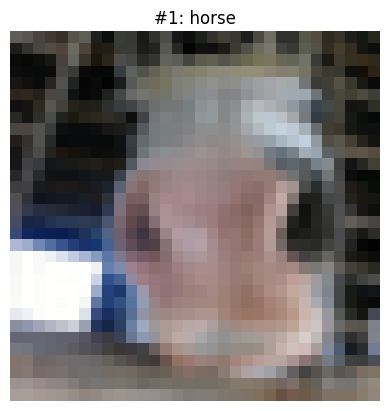

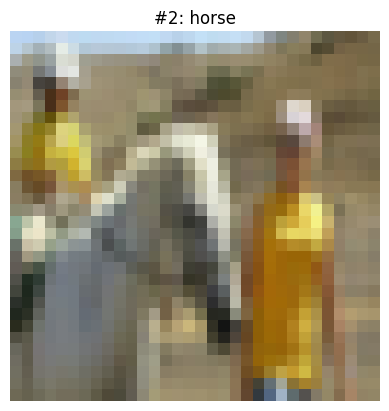

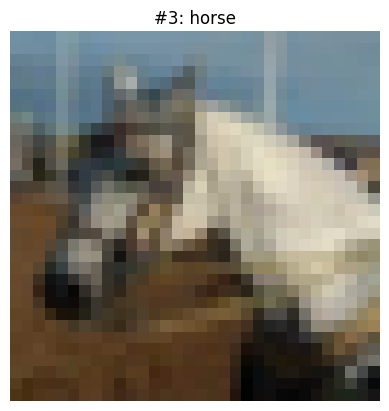

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


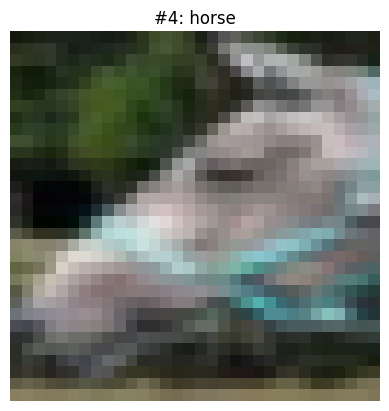

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


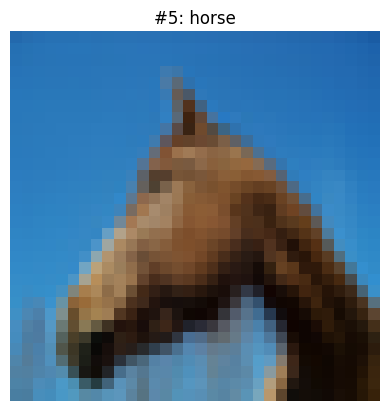

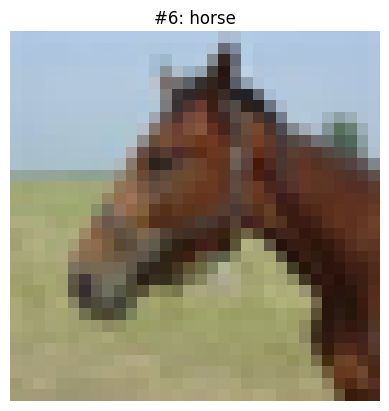

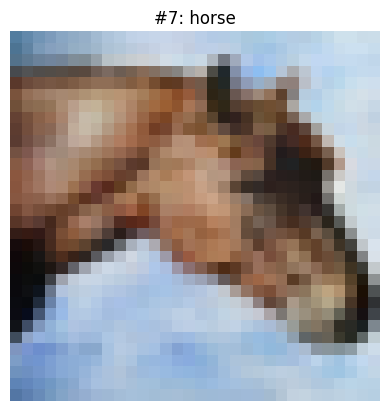

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


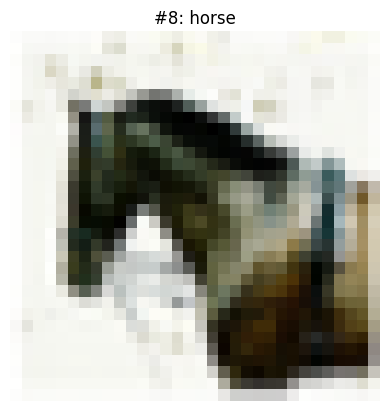

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


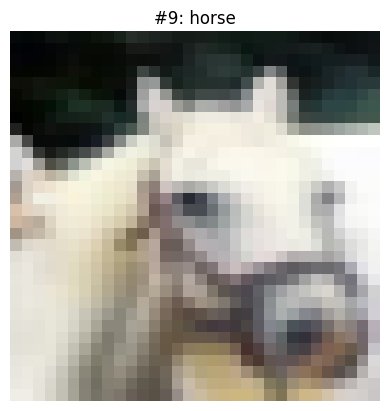

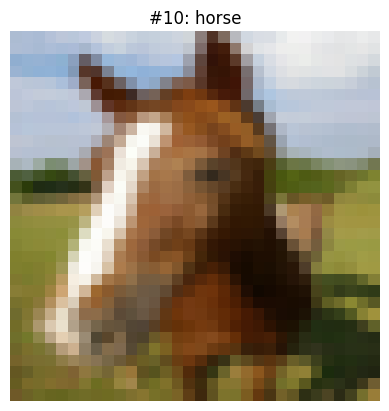

In [9]:
f_idx = 195 #change index to specify non-silent feature
f_acts = encoded[:, f_idx]
top_act_idxs = f_acts.abs().squeeze().topk(10)[1]
mu = np.array([0.4914, 0.4822, 0.4465]).reshape(1, 1, 3) #values taken from readme of https://github.com/huyvnphan/PyTorch_CIFAR10
sigma = np.array([0.2471, 0.2435, 0.2616]).reshape(1, 1, 3)
downsample = torch.nn.MaxPool2d(2)
imgs = downsample(train_data.data.view((-1, 3, 64, 64))).detach()

print(f' Showing top activating inputs for feature {f_idx}:')
for i, top_idx in enumerate(top_act_idxs):
    img = np.transpose(np.squeeze(imgs[top_idx, :, :, :]), axes=(1, 2, 0))
    img = img*sigma + mu
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'#{i+1}: {cifar10_labels[train_data.targets[top_idx].item()]}')
    #plt.savefig(f"figures_mlp/f{f_idx}_num{i+1}_top_img.pdf", format="pdf", bbox_inches="tight")
    plt.show()



Sensitivity/specificity 

In [10]:
glob_idx = 195
idxs4labels = {v: k for k, v in cifar10_labels.items()}
l_idx = idxs4labels[class2find]
l_occur_mask = (train_data.targets == l_idx)
n_occur = l_occur_mask.sum()
n_active_cond = (encoded[l_occur_mask, glob_idx] != 0).sum()
sensitivity = n_active_cond / n_occur
active_mask = (encoded[:, glob_idx].squeeze() != 0)
n_active = active_mask.sum()
n_occur_cond = (train_data.targets[active_mask] == l_idx).sum()
specificity = n_occur_cond / n_active
print(f"Sensitivity of feature {glob_idx} to hypothesised class {class2find}: {sensitivity}")
print(f"Specificity of feature {glob_idx} to hypothesised class {class2find}: {specificity}")

Sensitivity of feature 195 to hypothesised class horse: 1.0
Specificity of feature 195 to hypothesised class horse: 0.10364057123661041


On/off is a very coarse way of looking at feature activations. Better to compute sensitivity/specificity for different activation levels.

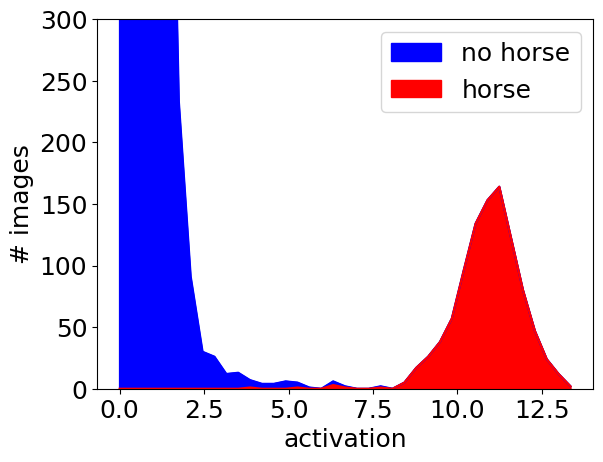

In [24]:
glob_idx = 195
label = class2find
n_bins = 40
l_idx = idxs4labels[class2find]
sing_f_acts = encoded[:, glob_idx]
max_act = sing_f_acts.max().item()
min_act = sing_f_acts.min().item()
act_bins = np.linspace(min_act, max_act, num=n_bins)    

num_TA = np.empty((n_bins-1))
num_FA = np.empty((n_bins-1))
for i_bin in range(len(act_bins)-1):
    left = act_bins[i_bin]
    right = act_bins[i_bin+1] 
    bin_act_mask = torch.logical_and(sing_f_acts.squeeze().abs() > left, sing_f_acts.squeeze().abs() < right)
    TA = (train_data.targets[bin_act_mask] == l_idx).sum()
    FA = bin_act_mask.sum() - TA
    num_TA[i_bin] = TA
    num_FA[i_bin] = FA

midpoints = [(act_bins[ileft]+act_bins[ileft])/2 for ileft in range(len(act_bins)-1)]
# Plotting the lines
plt.plot(midpoints, num_TA + num_FA, color='blue')    
plt.plot(midpoints, num_TA, color='red')

# Filling the areas
plt.fill_between(midpoints, num_TA, num_TA + num_FA, color='blue', label='no ' + label)
plt.fill_between(midpoints, 0, num_TA, color='red', label=label)
plt.ylim([0, 300])
_ = plt.xlabel(f"activation")
_ = plt.ylabel('# images')
# _ = plt.title(f'F{glob_idx} with hypothesized meaning "{label}"')
_ = plt.legend(loc='upper right')
plt.savefig(f"figures_mlp/f{f_idx}_sensitivity_by_act_{class2find}.png", format="png", bbox_inches="tight")

Recompute sensitivity/specificity while only considering the feature to be "active" if its activation is larger than 8.

In [13]:
glob_idx = 195
thres = 7
idxs4labels = {v: k for k, v in cifar10_labels.items()}
l_idx = idxs4labels[class2find]
l_occur_mask = (train_data.targets == l_idx)
n_occur = l_occur_mask.sum()
n_active_cond = (encoded[l_occur_mask, glob_idx] > thres).sum()
sensitivity = n_active_cond / n_occur
active_mask = (encoded[:, glob_idx].squeeze() > thres)
n_active = active_mask.sum()
n_occur_cond = (train_data.targets[active_mask] == l_idx).sum()
specificity = n_occur_cond / n_active
print(f"Sensitivity of feature {glob_idx} to hypothesized class {class2find}: {sensitivity}")
print(f"Specificity of feature {glob_idx} to hypothesized class {class2find}: {specificity}")

Sensitivity of feature 195 to hypothesized class horse: 0.9939086437225342
Specificity of feature 195 to hypothesized class horse: 0.9989795684814453


Investigate downstream effects of feature

In [25]:
#########deleting SAE and loading VGG to save memory##################################
glob_idx = 195
f_vec = sparse_autoencoder.W_dec[glob_idx, :].squeeze()
del sparse_autoencoder

# Define the model and specify the pre-trained weights
mlp = get_model(architecture=architecture, resolution=crop_resolution, num_classes=CLASS_DICT[dataset],
                  checkpoint='in21k_cifar10')
#######################################################################################

Weights already downloaded
Load_state output <All keys matched successfully>


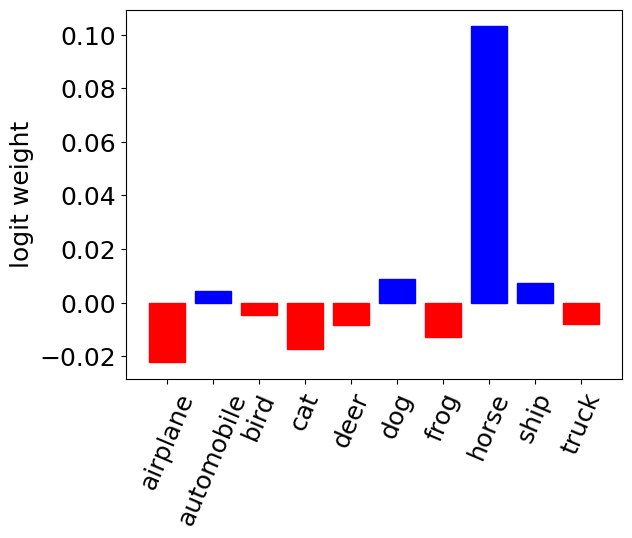

In [28]:
glob_idx = 195
label = class2find

W_down = mlp.linear_out.weight
logit_ws = W_down@f_vec

bars = plt.bar(cifar10_labels.values(), logit_ws.detach().numpy())
for bar in bars:
    if bar.get_height() < 0:
        bar.set_color('red')
    else:
        bar.set_color('blue')

# _ = plt.xlabel('classes') 
_ = plt.ylabel('logit weight')
_ = plt.xticks(rotation=67)
plt.savefig(f"figures_mlp/f{f_idx}_logit_weights.png", format="png", bbox_inches="tight")

Causal manipulations: artifically pin the feature at large value and observe its downstream effects on classification behavior, i.e., show that the feature is **causally** driving the prediction of a certain class.

Evaluation:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluation: 100%|██████████| 100/100 [01:17<00:00,  1.30it/s]


# of horse-predictions: 0


Evaluation: 100%|██████████| 100/100 [01:12<00:00,  1.39it/s]


# of horse-predictions: 0


Evaluation: 100%|██████████| 100/100 [01:17<00:00,  1.30it/s]


# of horse-predictions: 0


Evaluation: 100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


# of horse-predictions: 0


Evaluation: 100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


# of horse-predictions: 0


Evaluation: 100%|██████████| 100/100 [01:14<00:00,  1.35it/s]


# of horse-predictions: 973


Evaluation: 100%|██████████| 100/100 [01:12<00:00,  1.38it/s]


# of horse-predictions: 1005


Evaluation: 100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


# of horse-predictions: 9194


Evaluation: 100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


# of horse-predictions: 10000


Evaluation: 100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


# of horse-predictions: 10000


Evaluation: 100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


# of horse-predictions: 10000


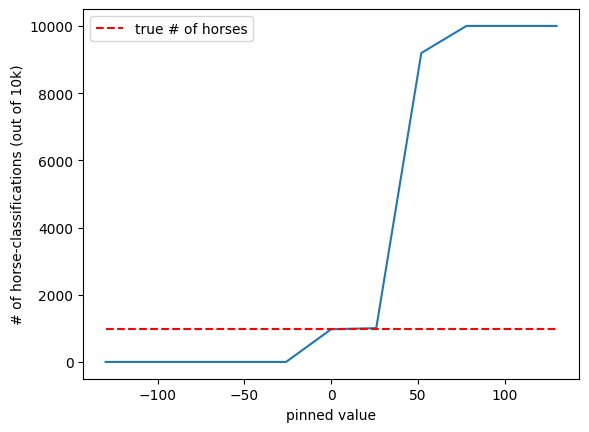

In [17]:
f_normed = f_vec / (f_vec.norm() + 1e-8)
pin_value = 0

def pin_hook(module, input, output):
    x = input[0]
    batch_size = x.shape[0]
    ablated = x-x@f_normed.view(-1, 1)@f_normed.view(1, -1)
    pinned = ablated + pin_value*f_normed.view(1, -1).expand(batch_size, -1)
    out = (module.weight@pinned.transpose(0, 1)).transpose(0, 1)
    return out

hook_mlp = mlp.linear_out.register_forward_hook(pin_hook)

with torch.no_grad():
    nsamples = train_data.targets.shape[0]
    total_acc, total_top5 = AverageMeter(), AverageMeter()
    batchsize = 100
    mlp.eval()
    dataloader = DataLoader(train_data, batch_size=batchsize, shuffle=False)
    label_idx = idxs4labels[label]
    pin_vals = np.linspace(-130, 130, 11)
    counts = []
    
    for val in pin_vals:
        pin_value = val
        counter = 0
        for imgs, targs in tqdm(dataloader, desc="Evaluation"):
            preds = mlp(imgs)
            hard_preds = preds.argmax(dim=1)
            counter += (hard_preds == label_idx).sum().item()
        
        print(f'# of {label}-predictions: {counter}')
        counts.append(counter)

hook_mlp.remove()

n_true_inst = (train_data.targets == l_idx).sum().item()
plt.plot(pin_vals, counts, linewidth=3)
plt.hlines(n_true_inst, pin_vals[0], pin_vals[-1], linestyles="dashed", colors="red", label=f"true # of {label}s")
_ = plt.xlabel('pinned value') 
_ = plt.ylabel(f'# of {label}-classifications')
_ = plt.legend()
plt.savefig(f"figures_mlp/f{f_idx}_pinned_num_{class2find}_preds.png", format="png", bbox_inches="tight")